In [1]:
# How to reload the saved dataset later
from datasets import Dataset

def load_saved_dataset(data_path="../../../data/flickr-faces-filtered/dataset"):
    """Load the previously saved dataset from disk"""
    saved_dataset = Dataset.load_from_disk(data_path)
    print(f"Loaded dataset with {len(saved_dataset)} items")
    print(f"Features: {saved_dataset.features}")
    return saved_dataset

# Example usage (uncomment to test):
dataset = load_saved_dataset()
print(f"First item: {dataset[0]}")

print("üí° Tip: Use load_saved_dataset() to reload your filtered dataset anytime!")


Loaded dataset with 690 items
Features: {'image': Image(mode=None, decode=True, id=None), 'text': Value(dtype='string', id=None), 'id': Value(dtype='int64', id=None), 'recaptioned': Value(dtype='bool', id=None), 'ethnicity': Value(dtype='string', id=None), 'skintone': Value(dtype='string', id=None), 'gender': Value(dtype='string', id=None), 'age_range': Value(dtype='string', id=None), 'hair_color': Value(dtype='string', id=None), 'hair_length': Value(dtype='string', id=None), 'hair_texture': Value(dtype='string', id=None), 'eye_color': Value(dtype='string', id=None), 'expression': Value(dtype='string', id=None), 'gaze': Value(dtype='string', id=None), 'lighting': Value(dtype='string', id=None), 'clothing': Value(dtype='string', id=None), 'angle': Value(dtype='string', id=None)}
First item: {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x129052C90>, 'text': "A close-up view of a woman's face smiling at the camera. She has dark hair and freckles on her face. S

In [2]:
dataset

Dataset({
    features: ['image', 'text', 'id', 'recaptioned', 'ethnicity', 'skintone', 'gender', 'age_range', 'hair_color', 'hair_length', 'hair_texture', 'eye_color', 'expression', 'gaze', 'lighting', 'clothing', 'angle'],
    num_rows: 690
})

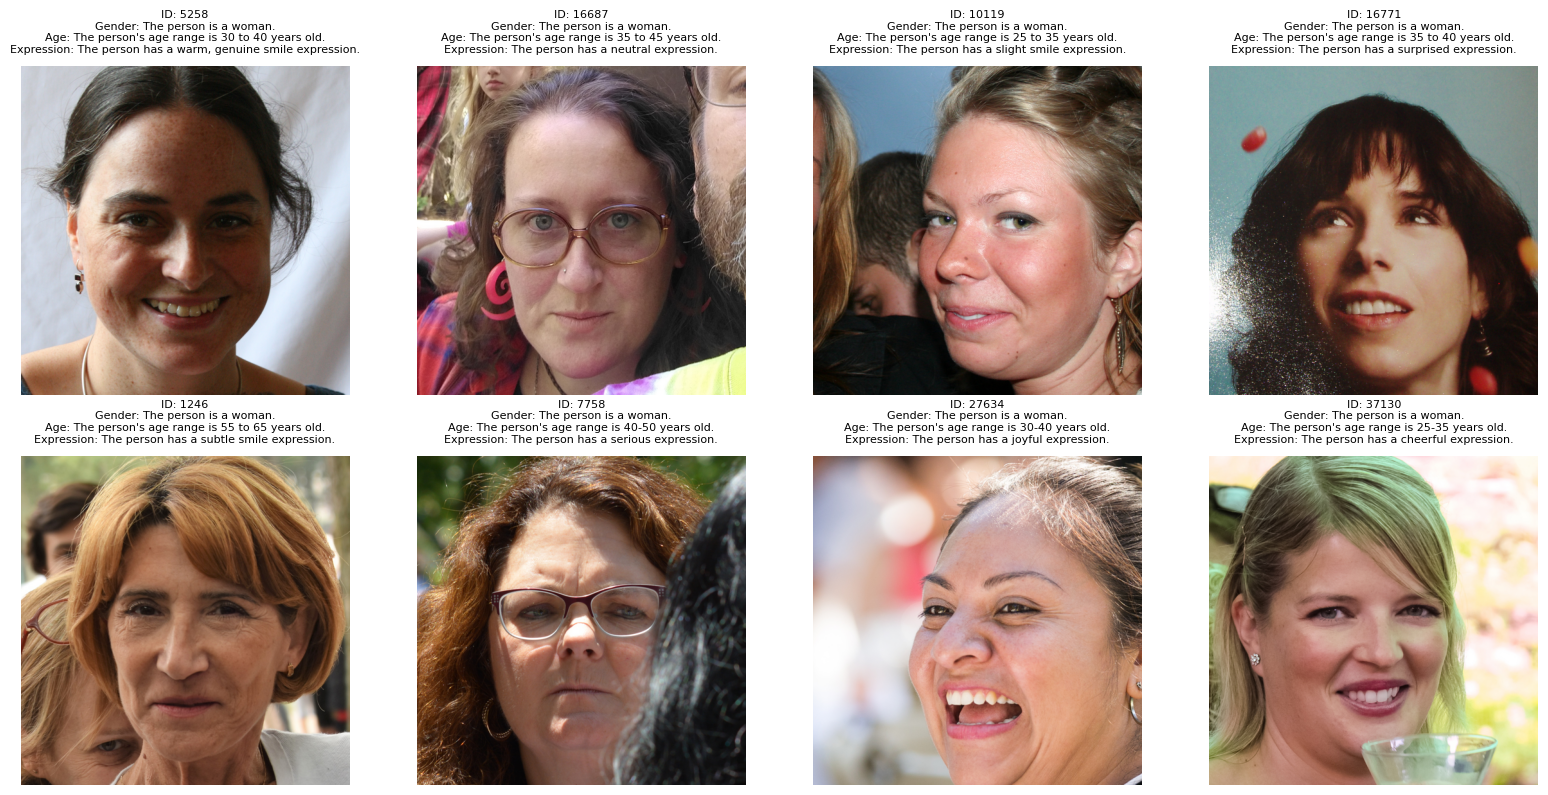

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Display the first few images in a grid
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    if i < len(dataset):
        # Display the image
        axes[i].imshow(dataset[i]['image'])
        axes[i].axis('off')
        
        # Add title with some attributes
        title = f"ID: {dataset[i]['id']}\n"
        title += f"Gender: {dataset[i]['gender']}\n"
        title += f"Age: {dataset[i]['age_range']}\n"
        title += f"Expression: {dataset[i]['expression']}"
        
        axes[i].set_title(title, fontsize=8, pad=10)
    else:
        axes[i].axis('off')

plt.tight_layout()
plt.show()


In [5]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import json
from datetime import datetime

class InteractiveFaceLabeler:
    def __init__(self, dataset):
        self.dataset = dataset
        self.current_index = 0
        self.labels = {}  # Store labels as {id: label}
        self.load_existing_labels()
        
        # Create widgets
        self.image_widget = widgets.Output()
        self.info_widget = widgets.HTML()
        self.progress_widget = widgets.HTML()
        self.stats_widget = widgets.HTML()
        
        # Create buttons
        self.hot_button = widgets.Button(
            description='üî• HOT (H)',
            button_style='success',
            layout=widgets.Layout(width='120px')
        )
        self.not_button = widgets.Button(
            description='‚ùÑÔ∏è NOT (N)', 
            button_style='danger',
            layout=widgets.Layout(width='120px')
        )
        self.skip_button = widgets.Button(
            description='‚è≠Ô∏è SKIP (S)',
            button_style='warning', 
            layout=widgets.Layout(width='120px')
        )
        self.prev_button = widgets.Button(
            description='‚¨ÖÔ∏è PREV (P)',
            button_style='info',
            layout=widgets.Layout(width='120px')
        )
        self.save_button = widgets.Button(
            description='üîÑ UPDATE',
            button_style='primary',
            layout=widgets.Layout(width='120px')
        )
        self.stats_button = widgets.Button(
            description='üìä STATS',
            button_style='info',
            layout=widgets.Layout(width='120px')
        )
        
        # Navigation widgets
        self.index_input = widgets.IntText(
            value=0,
            description='Go to:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='150px')
        )
        self.go_button = widgets.Button(
            description='GO',
            layout=widgets.Layout(width='60px')
        )
        
        # Bind events
        self.hot_button.on_click(lambda b: self.label_image('hot'))
        self.not_button.on_click(lambda b: self.label_image('not'))
        self.skip_button.on_click(lambda b: self.next_image())
        self.prev_button.on_click(lambda b: self.prev_image())
        self.save_button.on_click(lambda b: self.save_labels())
        self.go_button.on_click(lambda b: self.go_to_index())
        
        # Layout
        button_row1 = widgets.HBox([self.hot_button, self.not_button, self.skip_button])
        button_row2 = widgets.HBox([self.prev_button, self.save_button])
        nav_row = widgets.HBox([self.index_input, self.go_button])
        
        self.ui = widgets.VBox([
            self.progress_widget,
            self.stats_widget,
            self.info_widget,
            self.image_widget,
            button_row1,
            button_row2,
            nav_row
        ])
        
        self.update_display()
    
    def load_existing_labels(self):
        """Load previously saved labels"""
        try:
            with open('face_labels.json', 'r') as f:
                self.labels = json.load(f)
                # Convert string keys back to int
                self.labels = {int(k): v for k, v in self.labels.items()}
            print(f"üìÅ Loaded {len(self.labels)} existing labels")
        except FileNotFoundError:
            self.labels = {}
            print("üìù Starting fresh - no existing labels found")
    
    def save_labels(self):
        """Update the dataset locally with labels - no disk saving"""
        # Update the dataset with labels column locally
        self.update_dataset_with_labels()
        
        print(f"‚úÖ Updated dataset locally with {len(self.labels)} labels")
    
    def update_dataset_with_labels(self):
        """Update the local dataset with hot_or_not labels as a new column"""
        # Create labels column for all images
        hot_or_not_labels = []
        
        for item in self.dataset:
            img_id = item['id']
            label = self.labels.get(img_id, None)  # None for unlabeled
            hot_or_not_labels.append(label)
        
        # Add the new column to the dataset (or update if it already exists)
        try:
            # If hot_or_not column already exists, remove it first
            if 'hot_or_not' in self.dataset.column_names:
                self.dataset = self.dataset.remove_columns(['hot_or_not'])
            
            # Add the updated column
            updated_dataset = self.dataset.add_column('hot_or_not', hot_or_not_labels)
            
            # Update both local and global dataset references
            self.dataset = updated_dataset
            global dataset
            dataset = updated_dataset
            
        except Exception as e:
            print(f"‚ö†Ô∏è Error updating dataset: {e}")
            return
        
        print(f"üìä Label stats: {len([l for l in hot_or_not_labels if l == 'hot'])} hot, {len([l for l in hot_or_not_labels if l == 'not'])} not, {len([l for l in hot_or_not_labels if l is None])} unlabeled")
    
    def label_image(self, label):
        """Label current image and move to next"""
        img_id = self.dataset[self.current_index]['id']
        self.labels[img_id] = label
        print(f"‚ú® Labeled ID {img_id} as '{label}'")
        self.next_image()
    
    def next_image(self):
        """Move to next unlabeled image"""
        start_index = self.current_index
        attempts = 0
        while attempts < len(self.dataset):
            self.current_index = (self.current_index + 1) % len(self.dataset)
            img_id = self.dataset[self.current_index]['id']
            attempts += 1
            
            # Stop if we found an unlabeled image or cycled through all
            if img_id not in self.labels:
                break
        
        self.update_display()
    
    def prev_image(self):
        """Move to previous image"""
        self.current_index = (self.current_index - 1) % len(self.dataset)
        self.update_display()
    
    def go_to_index(self):
        """Go to specific index"""
        if 0 <= self.index_input.value < len(self.dataset):
            self.current_index = self.index_input.value
            self.update_display()
    
    def update_display(self):
        """Update the display with current image and info"""
        item = self.dataset[self.current_index]
        img_id = item['id']
        
        # Update progress
        labeled_count = len(self.labels)
        total_count = len(self.dataset)
        progress_pct = (labeled_count / total_count) * 100
        
        current_label = self.labels.get(img_id, "UNLABELED")
        label_color = {
            'hot': 'üî•',
            'not': '‚ùÑÔ∏è',
            'UNLABELED': '‚ùì'
        }.get(current_label, '‚ùì')
        
        self.progress_widget.value = f"""
        <div style="background: linear-gradient(90deg, #4CAF50 0%, #4CAF50 {progress_pct}%, #e0e0e0 {progress_pct}%, #e0e0e0 100%); height: 20px; border-radius: 10px; margin: 10px 0;"></div>
        <h3>Progress: {labeled_count}/{total_count} ({progress_pct:.1f}%)</h3>
        <h4>Image {self.current_index + 1} - ID: {img_id} - Current: {label_color} {current_label}</h4>
        """
        
        # Update image
        with self.image_widget:
            clear_output(wait=True)
            import matplotlib.pyplot as plt
            
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            ax.imshow(item['image'])
            ax.axis('off')
            ax.set_title(f"ID: {img_id} | Status: {current_label}", fontsize=14, pad=20)
            plt.tight_layout()
            plt.show()
        
        # Update info
        self.info_widget.value = f"""
        <div style="background-color: #f8f9fa; padding: 15px; border-radius: 8px; border-left: 4px solid #007acc;">
        <strong>üìä Attributes:</strong><br>
        ‚Ä¢ <strong>Gender:</strong> {item.get('gender', 'N/A')}<br>
        ‚Ä¢ <strong>Age:</strong> {item.get('age_range', 'N/A')}<br>
        ‚Ä¢ <strong>Expression:</strong> {item.get('expression', 'N/A')}<br>
        ‚Ä¢ <strong>Ethnicity:</strong> {item.get('ethnicity', 'N/A')}<br>
        ‚Ä¢ <strong>Skin tone:</strong> {item.get('skintone', 'N/A')}<br>
        ‚Ä¢ <strong>Hair:</strong> {item.get('hair_color', 'N/A')} {item.get('hair_length', '')}<br>
        ‚Ä¢ <strong>Eyes:</strong> {item.get('eye_color', 'N/A')}<br>
        <br>
        <strong>‚å®Ô∏è Keyboard Shortcuts:</strong><br>
        Use the buttons above, or use keyboard shortcuts when cell is selected:<br>
        <kbd>H</kbd> = Hot | <kbd>N</kbd> = Not | <kbd>S</kbd> = Skip | <kbd>P</kbd> = Previous
        </div>
        """
        
        # Update index input
        self.index_input.value = self.current_index
    
    def show(self):
        """Display the labeling interface"""
        display(self.ui)
        print("üöÄ Interactive Face Labeler Ready!")
        print("üí° Tips:")
        print("  ‚Ä¢ Click buttons or use keyboard shortcuts")
        print("  ‚Ä¢ Labels are stored in memory as you work")
        print("  ‚Ä¢ Use UPDATE button to add labels to dataset")
        print("  ‚Ä¢ Images will auto-advance to unlabeled ones")

# Create and show the labeler
labeler = InteractiveFaceLabeler(dataset)
labeler.show()


üìÅ Loaded 2 existing labels


üöÄ Interactive Face Labeler Ready!
üí° Tips:
  ‚Ä¢ Click buttons or use keyboard shortcuts
  ‚Ä¢ Labels are stored in memory as you work
  ‚Ä¢ Use UPDATE button to add labels to dataset
  ‚Ä¢ Images will auto-advance to unlabeled ones


‚ú® Labeled ID 5258 as 'not'


‚ú® Labeled ID 10119 as 'not'


‚ú® Labeled ID 16771 as 'hot'


‚ú® Labeled ID 16771 as 'hot'


‚ú® Labeled ID 1246 as 'not'


‚ú® Labeled ID 7758 as 'not'


‚ú® Labeled ID 27634 as 'not'


‚ú® Labeled ID 37130 as 'not'


‚ú® Labeled ID 3923 as 'not'


‚ú® Labeled ID 2125 as 'not'


‚ú® Labeled ID 15066 as 'hot'


‚ú® Labeled ID 29029 as 'not'


‚ú® Labeled ID 2087 as 'not'


‚ú® Labeled ID 19294 as 'not'


‚ú® Labeled ID 31313 as 'not'


‚ú® Labeled ID 12570 as 'not'


‚ú® Labeled ID 16401 as 'not'


‚ú® Labeled ID 16816 as 'not'


‚ú® Labeled ID 19687 as 'hot'


‚ú® Labeled ID 10081 as 'hot'


‚ú® Labeled ID 868 as 'not'


‚ú® Labeled ID 30177 as 'not'


‚ú® Labeled ID 1526 as 'not'


‚ú® Labeled ID 26771 as 'not'


‚ú® Labeled ID 4759 as 'hot'


‚ú® Labeled ID 15854 as 'not'


‚ú® Labeled ID 35388 as 'not'


‚ú® Labeled ID 17636 as 'not'


‚ú® Labeled ID 34976 as 'not'


‚ú® Labeled ID 17335 as 'not'


‚ú® Labeled ID 8303 as 'hot'


‚ú® Labeled ID 30561 as 'hot'


‚ú® Labeled ID 2305 as 'not'


‚ú® Labeled ID 12237 as 'not'


‚ú® Labeled ID 11437 as 'hot'


‚ú® Labeled ID 25231 as 'not'


‚ú® Labeled ID 14292 as 'not'


‚ú® Labeled ID 32677 as 'not'


‚ú® Labeled ID 21751 as 'not'


‚ú® Labeled ID 8780 as 'hot'


‚ú® Labeled ID 24809 as 'not'


‚ú® Labeled ID 17508 as 'hot'


‚ú® Labeled ID 30357 as 'hot'


‚ú® Labeled ID 26859 as 'not'


‚ú® Labeled ID 29498 as 'not'


‚ú® Labeled ID 22337 as 'not'


‚ú® Labeled ID 3613 as 'not'


‚ú® Labeled ID 18535 as 'hot'


‚ú® Labeled ID 12982 as 'not'


‚ú® Labeled ID 30571 as 'not'


‚ú® Labeled ID 15203 as 'not'


‚ú® Labeled ID 29787 as 'not'


‚ú® Labeled ID 39912 as 'not'


‚ú® Labeled ID 22991 as 'not'


‚ú® Labeled ID 17284 as 'not'


‚ú® Labeled ID 9507 as 'not'


‚ú® Labeled ID 10730 as 'not'


‚ú® Labeled ID 18533 as 'not'


‚ú® Labeled ID 20390 as 'not'


‚ú® Labeled ID 4620 as 'hot'


‚ú® Labeled ID 38289 as 'not'


‚ú® Labeled ID 18629 as 'not'


‚ú® Labeled ID 28504 as 'not'


‚ú® Labeled ID 32006 as 'not'


‚ú® Labeled ID 29336 as 'not'


‚ú® Labeled ID 2708 as 'not'


‚ú® Labeled ID 5992 as 'not'


‚ú® Labeled ID 30120 as 'not'


‚ú® Labeled ID 12931 as 'hot'


‚ú® Labeled ID 22221 as 'not'


‚ú® Labeled ID 39973 as 'not'


‚ú® Labeled ID 17909 as 'not'


‚ú® Labeled ID 15467 as 'not'


‚ú® Labeled ID 5811 as 'hot'


‚ú® Labeled ID 4623 as 'not'


‚ú® Labeled ID 6879 as 'not'


‚ú® Labeled ID 30949 as 'not'


‚ú® Labeled ID 13036 as 'hot'


‚ú® Labeled ID 26440 as 'not'


‚ú® Labeled ID 34821 as 'not'


‚ú® Labeled ID 31905 as 'not'


‚ú® Labeled ID 24798 as 'not'


‚ú® Labeled ID 19244 as 'not'


‚ú® Labeled ID 1952 as 'not'


‚ú® Labeled ID 24192 as 'not'


‚ú® Labeled ID 19073 as 'not'


‚ú® Labeled ID 8585 as 'hot'


‚ú® Labeled ID 34328 as 'not'


‚ú® Labeled ID 23000 as 'not'


‚ú® Labeled ID 15358 as 'not'


‚ú® Labeled ID 17557 as 'not'


‚ú® Labeled ID 31004 as 'not'


‚ú® Labeled ID 26202 as 'not'


‚ú® Labeled ID 592 as 'not'


‚ú® Labeled ID 31773 as 'hot'


‚ú® Labeled ID 7574 as 'not'


‚ú® Labeled ID 6661 as 'not'


‚ú® Labeled ID 13125 as 'not'


‚ú® Labeled ID 2521 as 'hot'


‚ú® Labeled ID 12761 as 'not'


‚ú® Labeled ID 22020 as 'not'


‚ú® Labeled ID 30500 as 'hot'


‚ú® Labeled ID 27991 as 'not'


‚ú® Labeled ID 7483 as 'hot'


‚ú® Labeled ID 18515 as 'not'


‚ú® Labeled ID 30540 as 'not'


‚ú® Labeled ID 25133 as 'not'


‚ú® Labeled ID 15916 as 'hot'


‚ú® Labeled ID 20659 as 'not'


‚ú® Labeled ID 27223 as 'not'


‚ú® Labeled ID 36349 as 'not'


‚ú® Labeled ID 16939 as 'not'


‚ú® Labeled ID 15631 as 'hot'


‚ú® Labeled ID 3344 as 'not'


‚ú® Labeled ID 10793 as 'not'


‚ú® Labeled ID 12153 as 'hot'


‚ú® Labeled ID 21840 as 'not'


‚ú® Labeled ID 31236 as 'not'


‚ú® Labeled ID 30613 as 'hot'


‚ú® Labeled ID 21387 as 'not'


‚ú® Labeled ID 13581 as 'not'


‚ú® Labeled ID 33812 as 'hot'


‚ú® Labeled ID 38880 as 'not'


‚ú® Labeled ID 38727 as 'hot'


‚ú® Labeled ID 32485 as 'not'


‚ú® Labeled ID 18868 as 'not'


‚ú® Labeled ID 6863 as 'not'


‚ú® Labeled ID 3708 as 'hot'


‚ú® Labeled ID 17235 as 'not'


‚ú® Labeled ID 24219 as 'not'


‚ú® Labeled ID 1727 as 'not'


‚ú® Labeled ID 11864 as 'not'


‚ú® Labeled ID 1604 as 'not'


‚ú® Labeled ID 7514 as 'hot'


‚ú® Labeled ID 18310 as 'not'


‚ú® Labeled ID 25487 as 'not'


‚ú® Labeled ID 40431 as 'not'


‚ú® Labeled ID 22452 as 'not'


‚ú® Labeled ID 14614 as 'hot'


‚ú® Labeled ID 36888 as 'not'


‚ú® Labeled ID 18701 as 'hot'


‚ú® Labeled ID 39435 as 'hot'


‚ú® Labeled ID 7193 as 'not'


‚ú® Labeled ID 24762 as 'not'


‚ú® Labeled ID 4452 as 'not'


‚ú® Labeled ID 1632 as 'not'


‚ú® Labeled ID 2824 as 'not'


‚ú® Labeled ID 4414 as 'hot'


‚ú® Labeled ID 6203 as 'not'


‚ú® Labeled ID 18040 as 'not'


‚ú® Labeled ID 16721 as 'hot'


‚ú® Labeled ID 34784 as 'not'


‚ú® Labeled ID 20483 as 'not'


‚ú® Labeled ID 10340 as 'not'


‚ú® Labeled ID 12754 as 'not'


‚ú® Labeled ID 39254 as 'not'


‚ú® Labeled ID 38187 as 'not'


‚ú® Labeled ID 35508 as 'not'


‚ú® Labeled ID 15636 as 'not'


‚ú® Labeled ID 21397 as 'not'


‚ú® Labeled ID 11785 as 'not'


‚ú® Labeled ID 5323 as 'not'


‚ú® Labeled ID 37434 as 'not'


‚ú® Labeled ID 20453 as 'hot'


‚ú® Labeled ID 1962 as 'hot'


‚ú® Labeled ID 9000 as 'hot'


‚ú® Labeled ID 16751 as 'not'


‚ú® Labeled ID 11598 as 'not'


‚ú® Labeled ID 20536 as 'not'


‚ú® Labeled ID 24950 as 'not'


‚ú® Labeled ID 38625 as 'not'


‚ú® Labeled ID 8526 as 'not'


‚ú® Labeled ID 22370 as 'not'


‚ú® Labeled ID 26305 as 'not'


‚ú® Labeled ID 20504 as 'not'


‚ú® Labeled ID 18469 as 'not'


‚ú® Labeled ID 17278 as 'not'


‚ú® Labeled ID 17828 as 'not'


‚ú® Labeled ID 33148 as 'not'


‚ú® Labeled ID 39317 as 'not'


‚ú® Labeled ID 21685 as 'hot'


‚ú® Labeled ID 18402 as 'not'


‚ú® Labeled ID 25841 as 'not'


‚ú® Labeled ID 22996 as 'hot'


‚ú® Labeled ID 21105 as 'not'


‚ú® Labeled ID 17052 as 'not'


‚ú® Labeled ID 37569 as 'not'


‚ú® Labeled ID 1617 as 'hot'


‚ú® Labeled ID 8808 as 'not'


‚ú® Labeled ID 31257 as 'not'


‚ú® Labeled ID 29932 as 'not'


‚ú® Labeled ID 8023 as 'not'


‚ú® Labeled ID 22340 as 'not'


‚ú® Labeled ID 21379 as 'not'


‚ú® Labeled ID 20011 as 'not'


‚ú® Labeled ID 28740 as 'not'


‚ú® Labeled ID 31472 as 'hot'


‚ú® Labeled ID 36874 as 'not'


‚ú® Labeled ID 24823 as 'not'


‚ú® Labeled ID 6063 as 'not'


‚ú® Labeled ID 10107 as 'not'


‚ú® Labeled ID 34883 as 'hot'


‚ú® Labeled ID 25119 as 'not'


‚ú® Labeled ID 39841 as 'not'


‚ú® Labeled ID 31290 as 'not'


‚ú® Labeled ID 8682 as 'not'


‚ú® Labeled ID 14377 as 'not'


‚ú® Labeled ID 40029 as 'not'


‚ú® Labeled ID 7612 as 'hot'


‚ú® Labeled ID 40663 as 'not'


‚ú® Labeled ID 14471 as 'not'


‚ú® Labeled ID 5100 as 'not'


‚ú® Labeled ID 35307 as 'hot'


‚ú® Labeled ID 30937 as 'not'


‚ú® Labeled ID 21572 as 'hot'


‚ú® Labeled ID 21226 as 'not'


‚ú® Labeled ID 39520 as 'not'


‚ú® Labeled ID 40790 as 'hot'


‚ú® Labeled ID 18548 as 'not'


‚ú® Labeled ID 3712 as 'not'


‚ú® Labeled ID 6352 as 'not'


‚ú® Labeled ID 2128 as 'not'


‚ú® Labeled ID 11108 as 'not'


‚ú® Labeled ID 26870 as 'not'


‚ú® Labeled ID 34107 as 'not'


‚ú® Labeled ID 32377 as 'not'


‚ú® Labeled ID 26395 as 'not'


‚ú® Labeled ID 7969 as 'hot'


‚ú® Labeled ID 15700 as 'not'


‚ú® Labeled ID 3261 as 'not'


‚ú® Labeled ID 32926 as 'not'


‚ú® Labeled ID 6634 as 'not'


‚ú® Labeled ID 20222 as 'not'


‚ú® Labeled ID 35343 as 'not'


‚ú® Labeled ID 13111 as 'not'


‚ú® Labeled ID 5830 as 'hot'


‚ú® Labeled ID 30619 as 'not'


‚ú® Labeled ID 33786 as 'not'


‚ú® Labeled ID 29888 as 'not'


‚ú® Labeled ID 13132 as 'hot'


‚ú® Labeled ID 1651 as 'not'


‚ú® Labeled ID 21221 as 'not'


‚ú® Labeled ID 8130 as 'hot'


‚ú® Labeled ID 6230 as 'not'


‚ú® Labeled ID 6230 as 'not'


‚ú® Labeled ID 32200 as 'not'


‚ú® Labeled ID 5623 as 'not'


‚ú® Labeled ID 28408 as 'not'


‚ú® Labeled ID 20398 as 'not'


‚ú® Labeled ID 3730 as 'not'


‚ú® Labeled ID 31384 as 'hot'


‚ú® Labeled ID 15841 as 'not'


‚ú® Labeled ID 17065 as 'not'


‚ú® Labeled ID 4703 as 'not'


‚ú® Labeled ID 3029 as 'hot'


‚ú® Labeled ID 28519 as 'not'


‚ú® Labeled ID 8622 as 'not'


‚ú® Labeled ID 5516 as 'not'


‚ú® Labeled ID 2491 as 'not'


‚ú® Labeled ID 1200 as 'not'


‚ú® Labeled ID 36573 as 'not'


‚ú® Labeled ID 29120 as 'hot'


‚ú® Labeled ID 4524 as 'not'


‚ú® Labeled ID 24117 as 'not'


‚ú® Labeled ID 2246 as 'not'


‚ú® Labeled ID 5956 as 'not'


‚ú® Labeled ID 16461 as 'hot'


‚ú® Labeled ID 5669 as 'not'


‚ú® Labeled ID 11078 as 'not'


‚ú® Labeled ID 8609 as 'not'


‚ú® Labeled ID 3966 as 'hot'


‚ú® Labeled ID 39059 as 'not'


‚ú® Labeled ID 40844 as 'not'


‚ú® Labeled ID 11140 as 'not'


‚ú® Labeled ID 15525 as 'not'


‚ú® Labeled ID 30650 as 'not'


‚ú® Labeled ID 28215 as 'not'


‚ú® Labeled ID 2469 as 'not'


‚ú® Labeled ID 34530 as 'not'


‚ú® Labeled ID 23172 as 'not'


‚ú® Labeled ID 40182 as 'not'


‚ú® Labeled ID 39979 as 'not'


‚ú® Labeled ID 10072 as 'not'


‚ú® Labeled ID 7503 as 'not'


‚ú® Labeled ID 18270 as 'not'


‚ú® Labeled ID 38115 as 'not'


‚ú® Labeled ID 21859 as 'not'


‚ú® Labeled ID 2584 as 'not'


‚ú® Labeled ID 36469 as 'not'


‚ú® Labeled ID 24852 as 'not'


‚ú® Labeled ID 34627 as 'hot'


‚ú® Labeled ID 18721 as 'not'


‚ú® Labeled ID 23450 as 'not'


‚ú® Labeled ID 39550 as 'not'


‚ú® Labeled ID 23728 as 'hot'


‚ú® Labeled ID 8110 as 'not'


‚ú® Labeled ID 4071 as 'not'


‚ú® Labeled ID 19974 as 'not'


‚ú® Labeled ID 27008 as 'not'


‚ú® Labeled ID 4525 as 'not'


‚ú® Labeled ID 19981 as 'hot'


‚ú® Labeled ID 31014 as 'not'


‚ú® Labeled ID 13396 as 'not'


‚ú® Labeled ID 21398 as 'not'


‚ú® Labeled ID 10843 as 'not'


‚ú® Labeled ID 3065 as 'not'


‚ú® Labeled ID 10994 as 'not'


‚ú® Labeled ID 7491 as 'not'


‚ú® Labeled ID 1646 as 'not'


‚ú® Labeled ID 31654 as 'hot'


‚ú® Labeled ID 23539 as 'not'


‚ú® Labeled ID 34232 as 'not'


‚ú® Labeled ID 31566 as 'not'


‚ú® Labeled ID 37325 as 'not'


‚ú® Labeled ID 25356 as 'not'


‚ú® Labeled ID 30418 as 'not'


‚ú® Labeled ID 11417 as 'not'


‚ú® Labeled ID 35772 as 'not'


‚ú® Labeled ID 9138 as 'not'


‚ú® Labeled ID 40277 as 'not'


‚ú® Labeled ID 39188 as 'not'


‚ú® Labeled ID 20302 as 'not'


‚ú® Labeled ID 3605 as 'not'


‚ú® Labeled ID 32016 as 'not'


‚ú® Labeled ID 27372 as 'hot'


‚ú® Labeled ID 19001 as 'not'


‚ú® Labeled ID 28369 as 'not'


‚ú® Labeled ID 36474 as 'not'


‚ú® Labeled ID 13147 as 'not'


‚ú® Labeled ID 3629 as 'hot'


‚ú® Labeled ID 33167 as 'hot'


‚ú® Labeled ID 9802 as 'hot'


‚ú® Labeled ID 31390 as 'not'


‚ú® Labeled ID 40350 as 'not'


‚ú® Labeled ID 14431 as 'hot'


‚ú® Labeled ID 34971 as 'not'


‚ú® Labeled ID 27023 as 'not'


‚ú® Labeled ID 9052 as 'not'


‚ú® Labeled ID 8825 as 'not'


‚ú® Labeled ID 17177 as 'not'


‚ú® Labeled ID 37868 as 'not'


‚ú® Labeled ID 10288 as 'not'


‚ú® Labeled ID 30525 as 'not'


‚ú® Labeled ID 12436 as 'not'


‚ú® Labeled ID 1013 as 'hot'


‚ú® Labeled ID 6641 as 'not'


‚ú® Labeled ID 1477 as 'not'


‚ú® Labeled ID 24182 as 'not'


‚ú® Labeled ID 22138 as 'hot'


‚ú® Labeled ID 32406 as 'hot'


‚ú® Labeled ID 38786 as 'not'


‚ú® Labeled ID 31372 as 'hot'


‚ú® Labeled ID 8567 as 'not'


‚ú® Labeled ID 25803 as 'not'


‚ú® Labeled ID 31829 as 'hot'


‚ú® Labeled ID 19611 as 'not'


‚ú® Labeled ID 251 as 'not'


‚ú® Labeled ID 12707 as 'not'


‚ú® Labeled ID 30659 as 'not'


‚ú® Labeled ID 33042 as 'not'


‚ú® Labeled ID 14002 as 'not'


‚ú® Labeled ID 16096 as 'hot'


‚ú® Labeled ID 3305 as 'not'


‚ú® Labeled ID 39787 as 'hot'


‚ú® Labeled ID 35785 as 'not'


‚ú® Labeled ID 38464 as 'not'


‚ú® Labeled ID 19308 as 'not'


‚ú® Labeled ID 15658 as 'not'


‚ú® Labeled ID 2250 as 'not'


‚ú® Labeled ID 27960 as 'hot'


‚ú® Labeled ID 3387 as 'not'


‚ú® Labeled ID 3511 as 'not'


‚ú® Labeled ID 560 as 'not'


‚ú® Labeled ID 2659 as 'hot'


‚ú® Labeled ID 15205 as 'hot'


‚ú® Labeled ID 34762 as 'not'


‚ú® Labeled ID 3583 as 'not'


‚ú® Labeled ID 28707 as 'hot'


‚ú® Labeled ID 4725 as 'not'


‚ú® Labeled ID 33755 as 'not'


‚ú® Labeled ID 37150 as 'not'


‚ú® Labeled ID 22590 as 'not'


‚ú® Labeled ID 21312 as 'not'


‚ú® Labeled ID 30963 as 'not'


‚ú® Labeled ID 13444 as 'not'


‚ú® Labeled ID 25247 as 'hot'


‚ú® Labeled ID 25247 as 'hot'


‚ú® Labeled ID 1175 as 'not'


‚ú® Labeled ID 32047 as 'not'


‚ú® Labeled ID 38977 as 'not'


‚ú® Labeled ID 3000 as 'not'


‚ú® Labeled ID 19525 as 'hot'


‚ú® Labeled ID 12823 as 'not'


‚ú® Labeled ID 16285 as 'hot'


‚ú® Labeled ID 21435 as 'not'


‚ú® Labeled ID 2233 as 'not'


‚ú® Labeled ID 11317 as 'hot'


‚ú® Labeled ID 15513 as 'not'


‚ú® Labeled ID 11238 as 'not'


‚ú® Labeled ID 37473 as 'not'


‚ú® Labeled ID 17607 as 'not'


‚ú® Labeled ID 37681 as 'not'


‚ú® Labeled ID 14323 as 'not'


‚ú® Labeled ID 33354 as 'not'


‚ú® Labeled ID 5916 as 'not'


‚ú® Labeled ID 11643 as 'not'


‚ú® Labeled ID 31662 as 'hot'


‚ú® Labeled ID 8700 as 'not'


‚ú® Labeled ID 2111 as 'not'


‚ú® Labeled ID 20177 as 'not'


‚ú® Labeled ID 2974 as 'not'


‚ú® Labeled ID 18825 as 'not'


‚ú® Labeled ID 32314 as 'not'


‚ú® Labeled ID 12694 as 'not'


‚ú® Labeled ID 25583 as 'not'


‚ú® Labeled ID 13140 as 'not'


‚ú® Labeled ID 2805 as 'not'


‚ú® Labeled ID 14314 as 'hot'


‚ú® Labeled ID 5785 as 'not'


‚ú® Labeled ID 36079 as 'not'


‚ú® Labeled ID 13131 as 'not'


‚ú® Labeled ID 14352 as 'not'


‚ú® Labeled ID 11349 as 'not'


‚ú® Labeled ID 32545 as 'hot'


‚ú® Labeled ID 23536 as 'not'


‚ú® Labeled ID 20703 as 'not'


‚ú® Labeled ID 12544 as 'hot'


‚ú® Labeled ID 17334 as 'not'


‚ú® Labeled ID 29475 as 'not'


‚ú® Labeled ID 3553 as 'not'


‚ú® Labeled ID 12391 as 'not'


‚ú® Labeled ID 26073 as 'not'


‚ú® Labeled ID 26630 as 'hot'


‚ú® Labeled ID 24275 as 'not'


‚ú® Labeled ID 36811 as 'not'


‚ú® Labeled ID 7107 as 'not'


‚ú® Labeled ID 1944 as 'not'


‚ú® Labeled ID 25789 as 'not'


‚ú® Labeled ID 27352 as 'not'


‚ú® Labeled ID 7736 as 'hot'


‚ú® Labeled ID 18881 as 'not'


‚ú® Labeled ID 33140 as 'not'


‚ú® Labeled ID 26145 as 'not'


‚ú® Labeled ID 35543 as 'not'


‚ú® Labeled ID 33144 as 'not'


‚ú® Labeled ID 4945 as 'not'


‚ú® Labeled ID 13027 as 'not'


‚ú® Labeled ID 35611 as 'not'


‚ú® Labeled ID 25560 as 'not'


‚ú® Labeled ID 37315 as 'hot'


‚ú® Labeled ID 31040 as 'not'


‚ú® Labeled ID 16531 as 'not'


‚ú® Labeled ID 14001 as 'not'


‚ú® Labeled ID 114 as 'hot'


‚ú® Labeled ID 11754 as 'not'


‚ú® Labeled ID 2021 as 'not'


‚ú® Labeled ID 13139 as 'not'


‚ú® Labeled ID 26794 as 'not'


‚ú® Labeled ID 35505 as 'not'


‚ú® Labeled ID 39855 as 'not'


‚ú® Labeled ID 8012 as 'not'


‚ú® Labeled ID 38992 as 'hot'


‚ú® Labeled ID 40624 as 'hot'


‚ú® Labeled ID 38693 as 'not'


‚ú® Labeled ID 6768 as 'not'


‚ú® Labeled ID 13690 as 'not'


‚ú® Labeled ID 8565 as 'not'


‚ú® Labeled ID 17349 as 'not'


‚ú® Labeled ID 15709 as 'hot'


‚ú® Labeled ID 31034 as 'not'


‚ú® Labeled ID 12331 as 'not'


‚ú® Labeled ID 1005 as 'not'


‚ú® Labeled ID 2042 as 'not'


‚ú® Labeled ID 15535 as 'not'


‚ú® Labeled ID 37843 as 'hot'


‚ú® Labeled ID 10587 as 'hot'


‚ú® Labeled ID 40366 as 'not'


‚ú® Labeled ID 30895 as 'not'


‚ú® Labeled ID 33041 as 'not'


‚ú® Labeled ID 33041 as 'not'


‚ú® Labeled ID 38737 as 'not'


‚ú® Labeled ID 5777 as 'not'


‚ú® Labeled ID 34757 as 'hot'


‚ú® Labeled ID 8442 as 'not'


‚ú® Labeled ID 7417 as 'not'


‚ú® Labeled ID 27158 as 'hot'


‚ú® Labeled ID 15128 as 'not'


‚ú® Labeled ID 5294 as 'not'


‚ú® Labeled ID 35340 as 'hot'


‚ú® Labeled ID 16472 as 'not'


‚ú® Labeled ID 31562 as 'not'


‚ú® Labeled ID 34092 as 'not'


‚ú® Labeled ID 23262 as 'not'


‚ú® Labeled ID 1685 as 'not'


‚ú® Labeled ID 18859 as 'not'


‚ú® Labeled ID 23185 as 'not'


‚ú® Labeled ID 6963 as 'not'


‚ú® Labeled ID 32508 as 'not'


‚ú® Labeled ID 20940 as 'not'


‚ú® Labeled ID 19023 as 'not'


‚ú® Labeled ID 17645 as 'not'


‚ú® Labeled ID 33196 as 'not'


‚ú® Labeled ID 32740 as 'not'


‚ú® Labeled ID 17865 as 'not'


‚ú® Labeled ID 39369 as 'not'


‚ú® Labeled ID 33294 as 'hot'


‚ú® Labeled ID 24716 as 'not'


‚ú® Labeled ID 40022 as 'not'


‚ú® Labeled ID 31248 as 'not'


‚ú® Labeled ID 14778 as 'hot'


‚ú® Labeled ID 6051 as 'hot'


‚ú® Labeled ID 16972 as 'hot'


‚ú® Labeled ID 27863 as 'not'


‚ú® Labeled ID 5027 as 'not'


‚ú® Labeled ID 13789 as 'not'


‚ú® Labeled ID 6123 as 'not'


‚ú® Labeled ID 40626 as 'not'


‚ú® Labeled ID 28302 as 'hot'


‚ú® Labeled ID 14630 as 'not'


‚ú® Labeled ID 25440 as 'hot'


‚ú® Labeled ID 1393 as 'not'


‚ú® Labeled ID 19798 as 'not'


‚ú® Labeled ID 26103 as 'not'


‚ú® Labeled ID 31086 as 'not'


‚ú® Labeled ID 12696 as 'hot'


‚ú® Labeled ID 10511 as 'not'


‚ú® Labeled ID 3687 as 'not'


‚ú® Labeled ID 28555 as 'not'


‚ú® Labeled ID 27612 as 'not'


‚ú® Labeled ID 20515 as 'not'


‚ú® Labeled ID 1583 as 'not'


‚ú® Labeled ID 28479 as 'not'


‚ú® Labeled ID 12527 as 'hot'


‚ú® Labeled ID 24540 as 'not'


‚ú® Labeled ID 7201 as 'not'


‚ú® Labeled ID 22251 as 'not'


‚ú® Labeled ID 23281 as 'not'


‚ú® Labeled ID 30199 as 'not'


‚ú® Labeled ID 28250 as 'not'


‚ú® Labeled ID 31918 as 'not'


‚ú® Labeled ID 26868 as 'hot'


‚ú® Labeled ID 8827 as 'not'


‚ú® Labeled ID 19296 as 'not'


‚ú® Labeled ID 16402 as 'not'


‚ú® Labeled ID 5457 as 'not'


‚ú® Labeled ID 9777 as 'not'


‚ú® Labeled ID 10263 as 'not'


‚ú® Labeled ID 28282 as 'hot'


‚ú® Labeled ID 20780 as 'not'


‚ú® Labeled ID 25961 as 'not'


‚ú® Labeled ID 8783 as 'not'


‚ú® Labeled ID 10904 as 'not'


‚ú® Labeled ID 30714 as 'not'


‚ú® Labeled ID 5230 as 'not'


‚ú® Labeled ID 28911 as 'hot'


‚ú® Labeled ID 24963 as 'not'


‚ú® Labeled ID 3324 as 'hot'


‚ú® Labeled ID 9433 as 'not'


‚ú® Labeled ID 2911 as 'not'


‚ú® Labeled ID 31139 as 'not'


‚ú® Labeled ID 37734 as 'not'


‚ú® Labeled ID 40261 as 'not'


‚ú® Labeled ID 40079 as 'not'


‚ú® Labeled ID 24598 as 'hot'


‚ú® Labeled ID 11013 as 'hot'


‚ú® Labeled ID 20002 as 'not'


‚ú® Labeled ID 6168 as 'not'


‚ú® Labeled ID 5890 as 'hot'


‚ú® Labeled ID 14639 as 'not'


‚ú® Labeled ID 26054 as 'not'


‚ú® Labeled ID 18024 as 'hot'


‚ú® Labeled ID 5713 as 'not'


‚ú® Labeled ID 8004 as 'not'


‚ú® Labeled ID 25040 as 'not'


‚ú® Labeled ID 5097 as 'not'


‚ú® Labeled ID 36397 as 'hot'


‚ú® Labeled ID 21436 as 'not'


‚ú® Labeled ID 12837 as 'not'


‚ú® Labeled ID 20021 as 'not'


‚ú® Labeled ID 38766 as 'not'


‚ú® Labeled ID 14022 as 'not'


‚ú® Labeled ID 40780 as 'not'


‚ú® Labeled ID 21059 as 'not'


‚ú® Labeled ID 37311 as 'not'


‚ú® Labeled ID 1516 as 'not'


‚ú® Labeled ID 24930 as 'not'


‚ú® Labeled ID 17830 as 'not'


‚ú® Labeled ID 2282 as 'not'


‚ú® Labeled ID 24713 as 'not'


‚ú® Labeled ID 15194 as 'not'


‚ú® Labeled ID 17283 as 'hot'


‚ú® Labeled ID 31737 as 'not'


‚ú® Labeled ID 4382 as 'not'


‚ú® Labeled ID 19453 as 'not'


‚ú® Labeled ID 33819 as 'not'


‚ú® Labeled ID 17771 as 'not'


‚ú® Labeled ID 29751 as 'not'


‚ú® Labeled ID 17182 as 'not'


‚ú® Labeled ID 5355 as 'hot'


‚ú® Labeled ID 25309 as 'not'


‚ú® Labeled ID 13694 as 'not'


‚ú® Labeled ID 33225 as 'not'


‚ú® Labeled ID 23195 as 'not'


‚ú® Labeled ID 20272 as 'not'


‚ú® Labeled ID 6182 as 'not'


‚ú® Labeled ID 7328 as 'hot'


‚ú® Labeled ID 15775 as 'not'


‚ú® Labeled ID 17380 as 'not'


‚ú® Labeled ID 40238 as 'not'


‚ú® Labeled ID 26265 as 'not'


‚ú® Labeled ID 31070 as 'not'


‚ú® Labeled ID 38881 as 'not'


‚ú® Labeled ID 39295 as 'hot'


‚ú® Labeled ID 36134 as 'hot'


‚ú® Labeled ID 20541 as 'not'


‚ú® Labeled ID 40458 as 'not'


‚ú® Labeled ID 28091 as 'not'


‚ú® Labeled ID 10595 as 'not'


‚ú® Labeled ID 23575 as 'not'


‚ú® Labeled ID 14244 as 'not'


‚ú® Labeled ID 20671 as 'hot'


‚ú® Labeled ID 961 as 'not'


‚ú® Labeled ID 21338 as 'not'


‚ú® Labeled ID 13960 as 'not'


‚ú® Labeled ID 19819 as 'not'


‚ú® Labeled ID 28897 as 'hot'


‚ú® Labeled ID 30751 as 'not'


‚ú® Labeled ID 11968 as 'not'


‚ú® Labeled ID 20657 as 'not'


‚ú® Labeled ID 17313 as 'not'


‚ú® Labeled ID 12384 as 'not'


‚ú® Labeled ID 8408 as 'not'


‚ú® Labeled ID 25849 as 'not'


‚ú® Labeled ID 18666 as 'not'


‚ú® Labeled ID 8289 as 'not'


‚ú® Labeled ID 28756 as 'not'


‚ú® Labeled ID 18056 as 'not'


‚ú® Labeled ID 20092 as 'not'


‚ú® Labeled ID 14764 as 'not'


‚ú® Labeled ID 3953 as 'not'


‚ú® Labeled ID 15468 as 'hot'


‚ú® Labeled ID 32131 as 'not'


‚ú® Labeled ID 23859 as 'hot'


‚ú® Labeled ID 36641 as 'not'


‚ú® Labeled ID 4966 as 'not'


‚ú® Labeled ID 17173 as 'not'


‚ú® Labeled ID 10116 as 'hot'


‚ú® Labeled ID 13958 as 'not'


‚ú® Labeled ID 36665 as 'not'


‚ú® Labeled ID 4636 as 'not'


‚ú® Labeled ID 5099 as 'not'


‚ú® Labeled ID 25318 as 'not'


‚ú® Labeled ID 23463 as 'not'


‚ú® Labeled ID 26183 as 'not'


‚ú® Labeled ID 34977 as 'not'


‚ú® Labeled ID 15369 as 'not'


‚ú® Labeled ID 4381 as 'not'


‚ú® Labeled ID 26238 as 'not'


‚ú® Labeled ID 12439 as 'not'


‚ú® Labeled ID 4049 as 'not'


‚ú® Labeled ID 13488 as 'not'


‚ú® Labeled ID 19869 as 'not'


‚ú® Labeled ID 26835 as 'not'


‚ú® Labeled ID 2836 as 'not'


‚ú® Labeled ID 27087 as 'not'


‚ú® Labeled ID 26465 as 'not'


‚ú® Labeled ID 17559 as 'not'


‚ú® Labeled ID 26298 as 'not'


‚ú® Labeled ID 38543 as 'not'


‚ú® Labeled ID 15247 as 'not'


‚ú® Labeled ID 19779 as 'hot'


‚ú® Labeled ID 36789 as 'not'


‚ú® Labeled ID 39903 as 'not'


‚ú® Labeled ID 32810 as 'hot'


‚ú® Labeled ID 23393 as 'not'


‚ú® Labeled ID 13648 as 'not'


‚ú® Labeled ID 23555 as 'not'


‚ú® Labeled ID 19892 as 'not'


‚ú® Labeled ID 19935 as 'not'


‚ú® Labeled ID 27244 as 'not'


‚ú® Labeled ID 24357 as 'not'


‚ú® Labeled ID 27890 as 'not'


‚ú® Labeled ID 38476 as 'not'


‚ú® Labeled ID 23180 as 'not'


‚ú® Labeled ID 131 as 'hot'


‚ú® Labeled ID 5872 as 'not'


‚ú® Labeled ID 38790 as 'not'


‚ú® Labeled ID 15769 as 'not'


‚ú® Labeled ID 24199 as 'not'


‚ú® Labeled ID 37413 as 'not'


‚ú® Labeled ID 2197 as 'not'


‚ú® Labeled ID 33706 as 'not'


‚ú® Labeled ID 26556 as 'not'


‚ú® Labeled ID 26556 as 'not'


üìä Label stats: 125 hot, 565 not, 0 unlabeled
‚úÖ Updated dataset locally with 690 labels
üìä Label stats: 125 hot, 565 not, 0 unlabeled
‚úÖ Updated dataset locally with 690 labels


In [10]:
# Save the dataset locally
import os
from pathlib import Path

# Create directory to save the dataset
save_dir = Path("../../../data/flickr-faces-filtered/")
save_dir.mkdir(parents=True, exist_ok=True)

print(f"Saving dataset to: {save_dir.absolute()}")

# Option 1: Save as HuggingFace Dataset format (recommended for reloading)
dataset_path = save_dir / "dataset-with-labels"
dataset.save_to_disk(str(dataset_path))
print(f"‚úÖ Saved as HuggingFace Dataset format: {dataset_path}")

print(f"\nüéâ Dataset successfully saved in multiple formats!")
print(f"üìÅ All files saved to: {save_dir.absolute()}")
print(f"üìä Dataset size: {len(dataset)} items")

Saving dataset to: /Users/earlpotters/Documents/personal/blog/notes/Preference Based Finetuning/hot_or_not/../../../data/flickr-faces-filtered


Saving the dataset (0/1 shards):   0%|          | 0/690 [00:00<?, ? examples/s]

‚úÖ Saved as HuggingFace Dataset format: ../../../data/flickr-faces-filtered/dataset-with-labels

üéâ Dataset successfully saved in multiple formats!
üìÅ All files saved to: /Users/earlpotters/Documents/personal/blog/notes/Preference Based Finetuning/hot_or_not/../../../data/flickr-faces-filtered
üìä Dataset size: 690 items


=== DATASET STATISTICS ===
Total samples in dataset: 690

Total labeled samples: 690

Label distribution (from dataset):
  not: 565 samples (81.9%)
  hot: 125 samples (18.1%)

=== SUMMARY ===
Hot samples: 125
Not samples: 565
Hot to Not ratio: 0.22
‚ö†Ô∏è  Dataset is imbalanced - consider balancing for better training results


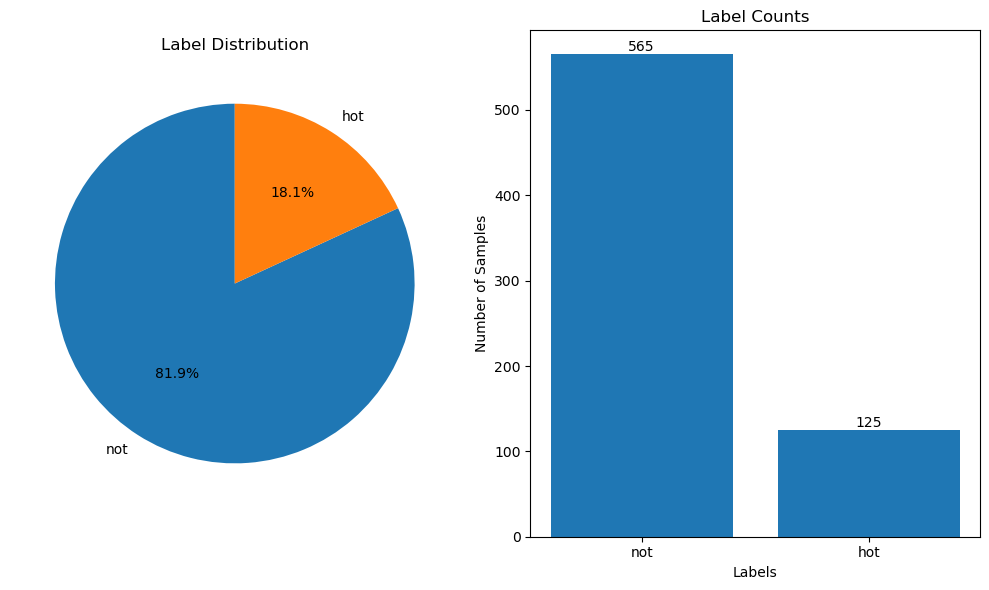

In [12]:
# Dataset Statistics for Hot or Not Labels (using `dataset` object)

import matplotlib.pyplot as plt
import pandas as pd

# Convert dataset to pandas DataFrame for easier analysis
df = dataset.to_pandas()

print("=== DATASET STATISTICS ===")
print(f"Total samples in dataset: {len(df)}")
print()

# Check if 'hot_or_not' or similar label column exists
label_col = None
for col in df.columns:
    if col.lower() in ['label', 'hot_or_not', 'hotnot', 'hot_not']:
        label_col = col
        break

if label_col is None:
    print("‚ùå No label column found in dataset! Please check your dataset columns.")
    print("Available columns:", list(df.columns))
else:
    label_counts = df[label_col].value_counts(dropna=False)
    total_labeled = label_counts.sum()
    print(f"Total labeled samples: {total_labeled}")
    print()

    print("Label distribution (from dataset):")
    for label, count in label_counts.items():
        percentage = (count / total_labeled) * 100
        print(f"  {label}: {count} samples ({percentage:.1f}%)")
    print()

    print("=== SUMMARY ===")
    print(f"Hot samples: {label_counts.get('hot', 0)}")
    print(f"Not samples: {label_counts.get('not', 0)}")

    if 'hot' in label_counts and 'not' in label_counts:
        ratio = label_counts['hot'] / label_counts['not'] if label_counts['not'] > 0 else float('inf')
        print(f"Hot to Not ratio: {ratio:.2f}")
        if ratio < 0.8 or ratio > 1.2:
            print("‚ö†Ô∏è  Dataset is imbalanced - consider balancing for better training results")
        else:
            print("‚úÖ Dataset appears reasonably balanced")

    # Visualization
    plt.figure(figsize=(10, 6))

    # Pie chart
    plt.subplot(1, 2, 1)
    plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Label Distribution')

    # Bar chart
    plt.subplot(1, 2, 2)
    plt.bar(label_counts.index.astype(str), label_counts.values)
    plt.title('Label Counts')
    plt.ylabel('Number of Samples')
    plt.xlabel('Labels')

    # Add count labels on bars
    for i, (label, count) in enumerate(label_counts.items()):
        plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Additional insights if we have timestamps
    if 'timestamp' in df.columns:
        print("\n=== LABELING TIMELINE ===")
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['date'] = df['timestamp'].dt.date

        daily_counts = df.groupby(['date', label_col]).size().unstack(fill_value=0)
        print("Daily labeling activity:")
        print(daily_counts)

        # Plot timeline
        plt.figure(figsize=(12, 6))
        if 'hot' in daily_counts.columns:
            plt.plot(daily_counts.index, daily_counts['hot'], marker='o', label='Hot', color='red')
        if 'not' in daily_counts.columns:
            plt.plot(daily_counts.index, daily_counts['not'], marker='s', label='Not', color='blue')

        plt.title('Labeling Activity Over Time')
        plt.xlabel('Date')
        plt.ylabel('Number of Labels')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
